<a href="https://colab.research.google.com/github/clint-bg/publicationdata/blob/main/safeDistancesOpenBurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heat Flux from Propellant, Fireworks, Flares, and an Organic Peroxide
***
## Approach: Estimate the safe distance from test data
This notebook treats the heat flux and its estimation based on open burning of propellant in drums or in fires. Confined scenarios or explosions are not treated hear. Clint Guymon, Safety Management Services, Inc.
***
## Conclusions: The safe distance is adequately captured by the existing HD1.3 siting distance

***
## Necessary code and data import

In [1]:
#Import necessary packages
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sea
from scipy.optimize import fsolve, minimize
from scipy.stats import t #import t distribution methods

### Import data

The majority of the heat flux data is from "Scaling Studies of Thermal Radiation Flux from Burning Propellants" by J. Hay and R.W. Watson of Bureau of Mines as commissioned by the DDESB in 1992. Various propellant types and masses were tested in a top down burn or external fire of a single barrel or package of propellant.

In [2]:
url = 'https://raw.githubusercontent.com/clint-bg/publicationdata/main/heatfluxdata.csv' #url with raw data
df = pd.read_csv(url)

In [3]:
#define a safe heat flux as a function of distance per second degree burns and a max exposure time of 20 seconds
#(per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns)
qsafeat20 = 0.116 #qsafe at 20 second exposure
def safeHF(t):
    return (t/0.858)**(-1/1.46) if t<20 else qsafeat20

In [4]:
#add new column for unique id = ref id + test id
df['Unique ID'] = df.agg('R{0[Reference ID]}T{0[Test #]}'.format, axis=1)
#add column for safe heat flux 
safeQ = df.groupby('Unique ID').apply(lambda x: np.percentile(
    [safeHF(x) for x in x['Burn time, sec']],75))
safeQ.name = 'Safe Heat Flux, cal/cm2/sec'
#add to dataframe
df['Safe Heat Flux, cal/cm2/sec'] = df['Unique ID'].apply(lambda x:safeQ.loc[x])

## Data summary

In [5]:
summary = df.groupby('Reference ID')['Reference'].unique().to_frame()
summary['Propellant types'] = df.groupby('Reference ID')['Propellant type'].unique()
summary['# of Tests'] = df.groupby('Reference ID')['Test #'].nunique()
summary

,Reference,Propellant types,# of Tests
Reference ID,,,
1,"[DDESB BOM ""SCALING STUDIES OF THERMAL RADIATI...","[IMR5010, M1-8-SP, M1-8-MP, WC844, WC846, WCBl...",49
2,"[TNO T 1022 ""Thermal Radiation of Fireworks"" 1...",[Fireworks],16
3,[DDESB IIT Research Institute R. Pape T. Water...,"[M1, WC844]",46
4,"[SMS C. Guymon ""Heat flux from the Top Ignitio...",[WC814],1
5,[China Lake Ranges Test Operation Branch (DB11...,[M1],1
6,"[ ""China Lake; Convective Combustion of Unconf...",[M1],2


In [6]:
#References
for i,each in enumerate(set(df['Reference'])):
    print(i,":",each) 

0 :  "China Lake; Convective Combustion of Unconfined HD 1.3 Material in Fiber Barrels; Presentation by Auston Bon et al."
1 : TNO T 1022 "Thermal Radiation of Fireworks" 1984
2 : DDESB IIT Research Institute R. Pape T. Waterman A. Takata "Fire Hazards from Combustible Ammunition, Methodology Development (Phase I)" 1980
3 : SMS C. Guymon "Heat flux from the Top Ignition of a Single Barrel of WC814" TEAD 2020
4 : DDESB BOM "SCALING STUDIES OF THERMAL RADIATION FLUX FROM BURNING PROPELLANTS" Hay and Watson 1992
5 : China Lake Ranges Test Operation Branch (DB1110M), "Convective Combustion of a Hazard Division 1.3 M1 Gun Propellant in Fiber Barrels Heat Flux Data, 20 March 2020


In [7]:
#propellant types
set(df['Propellant type'])

{'Fireworks',
 'IMR5010',
 'M1',
 'M1-8-MP',
 'M1-8-SP',
 'WC814',
 'WC844',
 'WC846',
 'WCBlank'}

In [8]:
#number of tests for each propellant
df.groupby('Propellant type')['Test #'].nunique()

Propellant type
Fireworks    16
IMR5010      13
M1           26
M1-8-MP      12
M1-8-SP      14
WC814         1
WC844        27
WC846         3
WCBlank       3
Name: Test #, dtype: int64

In [9]:
#total number of heat flux measurements
len(df)

316

In [10]:
df.describe() #summary statistics for numerical data

,Reference ID,"Mass, kg","Distance, m","Peak heat flux, cal/cm2/sec","Average heat flux, cal/cm2/sec","Burn time, sec","Safe Heat Flux, cal/cm2/sec"
count,316.000000,316.00000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,1.750000,76.04925,8.593196,0.602391,0.234888,32.304781,0.136222
std,1.167347,75.41618,5.381293,0.957516,0.339860,31.616435,0.033884
min,1.000000,0.34000,1.070000,0.001505,0.000579,3.500000,0.116000
25%,1.000000,45.40000,4.000000,0.072015,0.032000,15.000000,0.116000
50%,1.000000,49.90000,8.000000,0.280000,0.098000,21.900000,0.116000
75%,3.000000,95.30000,15.000000,0.654000,0.284659,36.587062,0.140897
max,6.000000,399.20000,20.000000,9.600000,2.400000,215.000000,0.381763


In [11]:
df.head(3) #first 3 rows of the data frame

,Reference ID,Reference,Propellant type,Test #,"Mass, kg","Distance, m","Peak heat flux, cal/cm2/sec","Average heat flux, cal/cm2/sec","Burn time, sec","total heat radiated, Mcal",Notes,"Drum diameter, cm",Unique ID,"Safe Heat Flux, cal/cm2/sec"
0,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,3.2,1.750,0.482,35.0,13.8,Barrel,60,R1T1,0.116
1,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,4.0,1.050,0.329,35.0,13.8,Barrel,60,R1T1,0.116
2,1,"DDESB BOM ""SCALING STUDIES OF THERMAL RADIATIO...",IMR5010,1,45.4,5.0,1.068,0.289,35.0,13.8,Barrel,60,R1T1,0.116


## Plot of the Safe Heat Flux vs. Exposure Time

Safe heat flux is per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns. with the included limit that after a duration of 20 seconds, the allowable heat flux remains constant at with increasing exposure time. 

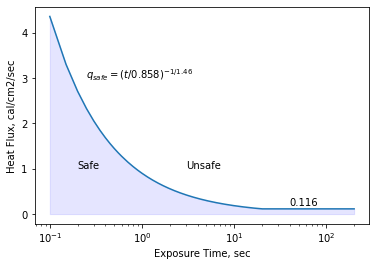

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
x = np.arange(.1,200,0.05); y=[safeHF(x) for x in x]; 
ax.set_xscale('log');
plt.plot(x,y);
ax.fill_between(x,y,color="blue", alpha=0.1)
plt.text(0.2, 1, 'Safe');plt.text(3, 1, 'Unsafe');plt.text(40, 0.2, '0.116') #, bbox=dict(facecolor='red', alpha=0.5))
plt.text(.25,3,'$q_{safe}=(t/0.858)^{-1/1.46}$')
plt.xlabel('Exposure Time, sec');plt.ylabel('Heat Flux, cal/cm2/sec')
plt.show(block=False)

Here, burn time is equated to the exposure time. After 20 seconds the allowed heat flux is constant at 0.116 cal/cm2/s

### Calculate a safe distance based on the point source model

Calculate a safe distance based on the average heat flux. The average heat flux is used instead of the peak heat flux as the peak heat flux is a short term event and is a small fraction of the total burn typically. The parameters of a Point Source Model are found according to the following where $r^2$ is the squared distance from the center of the fire: 
\begin{equation}
q = \frac{\alpha}{r^2} \\
\end{equation}

In [13]:
#completed for each test (unique id)
alphas = df.groupby('Unique ID').apply(lambda x: np.percentile(
    x['Average heat flux, cal/cm2/sec']*x['Distance, m']**2,75))
alphas = [1 if each < 1 else each for each in alphas]
safeDistance = np.sqrt(alphas/safeQ)
safeDistance = pd.Series(safeDistance)
safeDistance.name = 'Safe Distance, m'
safeDistance.index = safeQ.index

In [14]:
df['Safe Distance, m'] =  df['Unique ID'].apply(lambda x:safeDistance.loc[x])

In [15]:
mlin = np.linspace(1,100000,num=500)
ibd = [max(22.9,np.exp(1.4715+0.2429*np.log(each)+0.00384*(np.log(each))**2)) if each<43544 else np.exp(5.5938-0.5344*np.log(each)+0.04046*(np.log(each))**2) for each in mlin]
ibd = pd.DataFrame({'masses':mlin,'ibd':ibd})

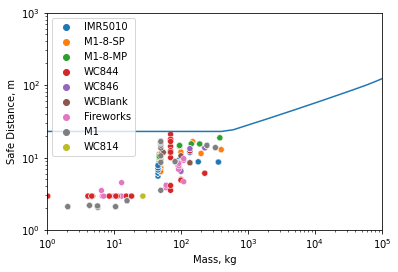

In [18]:
fig, ax = plt.subplots()
p = sea.scatterplot(data=df,x='Mass, kg',y='Safe Distance, m',hue='Propellant type',ax=ax);
p = sea.lineplot(data=ibd,x='masses',y='ibd',ax=ax)
p.set(xscale="log"); p.set(xlim=(1,100000))
p.set(yscale="log"); p.set(ylim=(1,1000))
plt.show()

## Add modeling results from COMSOL with Radiation in Participating Media
COMSOL modeling was completed with a representative barrel of burning material at a given burn rate and temperature with radiative propagation from the hot gases.

In [28]:
url='https://raw.githubusercontent.com/clint-bg/publicationdata/main/parametricstudy.csv'
dfm = pd.read_csv(url)
dft = pd.concat([df,dfm])

In [29]:
dfm.head()

,"Drum diameter, cm","Safe Distance, m","Burn rate, kg/s",Unique ID,Propellant type,"Mass, kg",Notes
0,36.0,7.493090,0.5,M1,Model,6.81,Mass estimated from burn rates (with base burn...
1,36.0,8.804850,1.0,M2,Model,13.62,Mass estimated from burn rates (with base burn...
2,36.0,9.279851,2.0,M3,Model,27.24,Mass estimated from burn rates (with base burn...
3,36.0,8.384938,5.0,M4,Model,68.10,Mass estimated from burn rates (with base burn...
4,36.0,6.826140,10.0,M5,Model,136.20,Mass estimated from burn rates (with base burn...


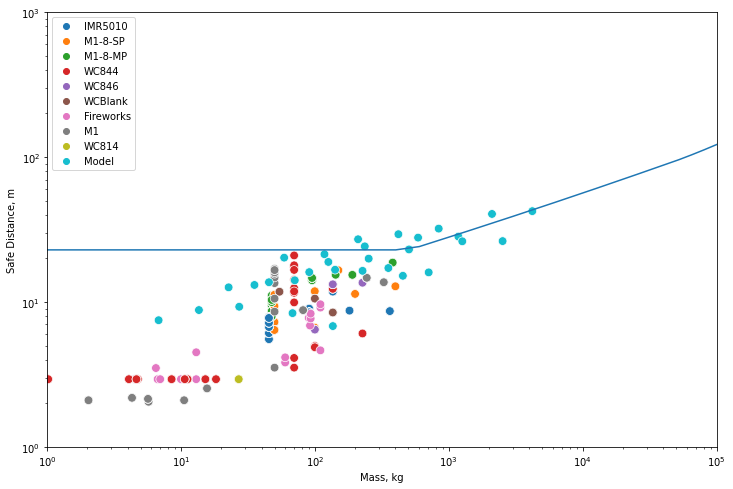

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
p = sea.scatterplot(data=dft,x='Mass, kg',y='Safe Distance, m',hue='Propellant type',s=75,ax=ax);
p = sea.lineplot(data=ibd,x='masses',y='ibd',ax=ax)
p.set(xscale="log"); p.set(xlim=(1,100000))
p.set(yscale="log"); p.set(ylim=(1,1000))
plt.show()

Note that there are many different ways that a safe distance could be estimated. The method used here is viewed by the authors as a conservative estimate. In previous plots, a modified version of the point source model with a 1/r dependence transitioning to a 1/r^2 dependence was used yielding slightly different results but with the same conclusion that the existing IBD line is effective in specifying a safe distance.